# Imports

In [257]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
import shap
from sklearn.svm import SVR

os.environ["KERAS_BACKEND"] = "jax"

from keras import Sequential
from keras.src.layers import Input, LSTM, Dense
from shap.plots import colors
from sklearn.ensemble import RandomForestRegressor as RandomForest
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from xgboost import XGBRegressor

SEED = 100


def reset_seed(rnd_seed=SEED):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(rnd_seed)
    np.random.seed(rnd_seed)
    tf.random.set_seed(rnd_seed)


reset_seed()



# Load Datasets



In [258]:
df = pd.read_csv('./dataset/elect_merged_selected.csv', sep=";", decimal=",", header=0)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df = df[df["date"] <= '2023-12-31']
df.set_index("date", inplace=True)

df_climatic = pd.read_csv('dataset/climatic.csv', sep=";", decimal=",", header=0)
df_climatic["date"] = pd.to_datetime(df_climatic["date"], format="%d/%m/%Y")
df_climatic.set_index("date", inplace=True)

df = df.astype("float32")

x = df.drop("consumption", axis=1)
y = df["consumption"]


# Best Params

In [259]:
best = {}
for model in ["LSTM", "RF", "SVR", "XGB"]:
    df_aux = pd.DataFrame()
    for optimizer in ["GA", "PSO"]:
        for seed, name in [("1000", "A"), ("2000", "B"), ("3000", "C")]:
            df_aux = pd.concat([df_aux,
                                pd.read_csv(f'params/{optimizer}-{model} ITERS SEED {seed}.csv', sep=";",
                                            decimal=",",
                                            header=0)], axis=0)
    df_aux = df_aux.sort_values(by=["Fitness"])
    df_aux[df_aux.isnull()] = None
    best[f"{model}"] = df_aux[:1].iloc[0].to_dict()

# Prediction

In [260]:
reset_seed()

#LSTM
tf.keras.backend.clear_session()
lstm = Sequential([
    Input((x.shape[1], 1)),
    LSTM(best["LSTM"]["Units"],
         activation=best["LSTM"]["Activation"],
         use_bias=best["LSTM"]["Bias"],
         seed=SEED),
    Dense(1),
])
lstm.compile(loss='mse')

#RF
rf = RandomForest(random_state=SEED,
                  n_estimators=int(best["RF"]["N_estimators"]),
                  max_depth=int(best["RF"]["Max_depth"]),
                  min_samples_split=int(best["RF"]["Min_samples_split"]),
                  min_samples_leaf=int(best["RF"]["Min_samples_leaf"]))

#SVR
svr = SVR(C=best["SVR"]["C"],
          epsilon=best["SVR"]["Epsilon"],
          kernel=best["SVR"]["Kernel"])

#XGB
updater = "coord_descent" if best["XGB"]["Booster"] == "gblinear" else None
xgb = XGBRegressor(random_state=SEED,
                   n_estimators=int(best["XGB"]["N_estimators"]),
                   max_depth=int(best["XGB"]["Max_depth"]),
                   booster=best["XGB"]["Booster"],
                   reg_lambda=best["XGB"]["Lambda"],
                   reg_alpha=best["XGB"]["Alpha"],
                   updater=updater)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=12, shuffle=False)

for i_train, i_test in TimeSeriesSplit(n_splits=16, test_size=1).split(x_train, y_train):
    kx_train, kx_test = x_train.iloc[i_train].to_numpy(), x_train.iloc[i_test].to_numpy()
    ky_train, ky_test = y_train.iloc[i_train].to_numpy(), y_train.iloc[i_test].to_numpy()

    xgb.fit(kx_train, ky_train)
    rf.fit(kx_train, ky_train)
    svr.fit(kx_train, ky_train)
    lstm.fit(kx_train, ky_train, shuffle=False, verbose=False, epochs=best["LSTM"]["Epochs"],
             batch_size=best["LSTM"]["Batch Size"])

preds = {
    "LSTM": [],
    "RF": [],
    "SVR": [],
    "XGB": []
}

datasets = {
    "LSTM": pd.concat([x_train.copy(), y_train.copy()], axis=1),
    "RF": pd.concat([x_train.copy(), y_train.copy()], axis=1),
    "SVR": pd.concat([x_train.copy(), y_train.copy()], axis=1),
    "XGB": pd.concat([x_train.copy(), y_train.copy()], axis=1)
}

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].astype(float)

    # Auxiliar array to  store the predictions for each model and update their lags
    sx_test_aux = {
        "LSTM": sx_test.copy(),
        "RF": sx_test.copy(),
        "SVR": sx_test.copy(),
        "XGB": sx_test.copy()
    }
    #Get the lags for each model based in the last prediction
    for model in ["LSTM", "RF", "SVR", "XGB"]:
        datasets[model] = pd.concat([datasets[model], sx_test_aux[model]], axis=0)
        for lag in range(1, 12 + 1):
            if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
                sx_test_aux[model][f'LAG_' + '{:02d}'.format(lag)] = datasets[model]["consumption"].shift(lag)
                datasets[model][f'LAG_' + '{:02d}'.format(lag)] = datasets[model]["consumption"].shift(lag)

    #Appends prediction in array of each model
    pred = {"LSTM": int(lstm.predict(sx_test_aux["LSTM"].copy().to_numpy())[0][0]),
            "RF": int(rf.predict(sx_test_aux["RF"].copy().to_numpy())[0]),
            "SVR": int(svr.predict(sx_test_aux["SVR"].copy().to_numpy())[0]),
            "XGB": int(xgb.predict(sx_test_aux["XGB"].copy().to_numpy())[0])}

    for model in ["LSTM", "RF", "SVR", "XGB"]:
        sx_test_aux[model]["consumption"] = pred[model]
        preds[model].append(pred[model])
        datasets[model].update(sx_test_aux[model])


1/1 [==============================] - 0s 82ms/step


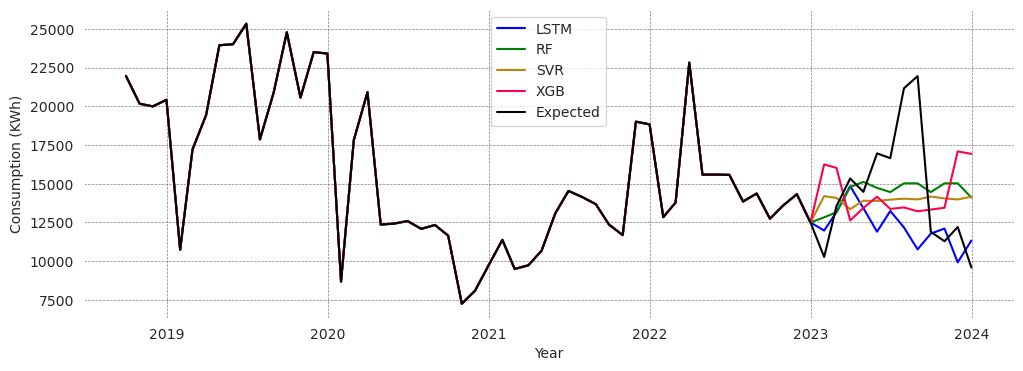

,LSTM,RF,SVR,XGB
MAE,3104.50000,2940.416667,3272.000000,4211.250000
MAPE,0.18237,0.206443,0.224331,0.301233


In [261]:
plt.figure(figsize=(12, 4))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["blue", "green", "darkgoldenrod", colors.red_rgb])

df_measures = pd.DataFrame(index=["MAE", "MAPE"])

for model in ["LSTM", "RF", "SVR", "XGB"]:
    plt.plot(df.index, np.concatenate((y_train.to_numpy(), preds[model])), label=model)
    df_measures[model] = pd.Series([mean_absolute_error(y_test.to_numpy(), preds[model]),
                                    mean_absolute_percentage_error(y_test.to_numpy(), preds[model])],
                                   index=["MAE", "MAPE"])

plt.plot(df["consumption"], label="Expected", color="black")

plt.xlabel('Year')
plt.ylabel('Consumption (KWh)')

ax = plt.gca()
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
plt.legend(facecolor='white')
plt.savefig("results/Forecast Results.png", bbox_inches='tight')
plt.show()

df_measures.to_csv(f"results/Measures.csv", sep=";", decimal=",", index=True)
df_measures


# SHAP Values
## Random Forest

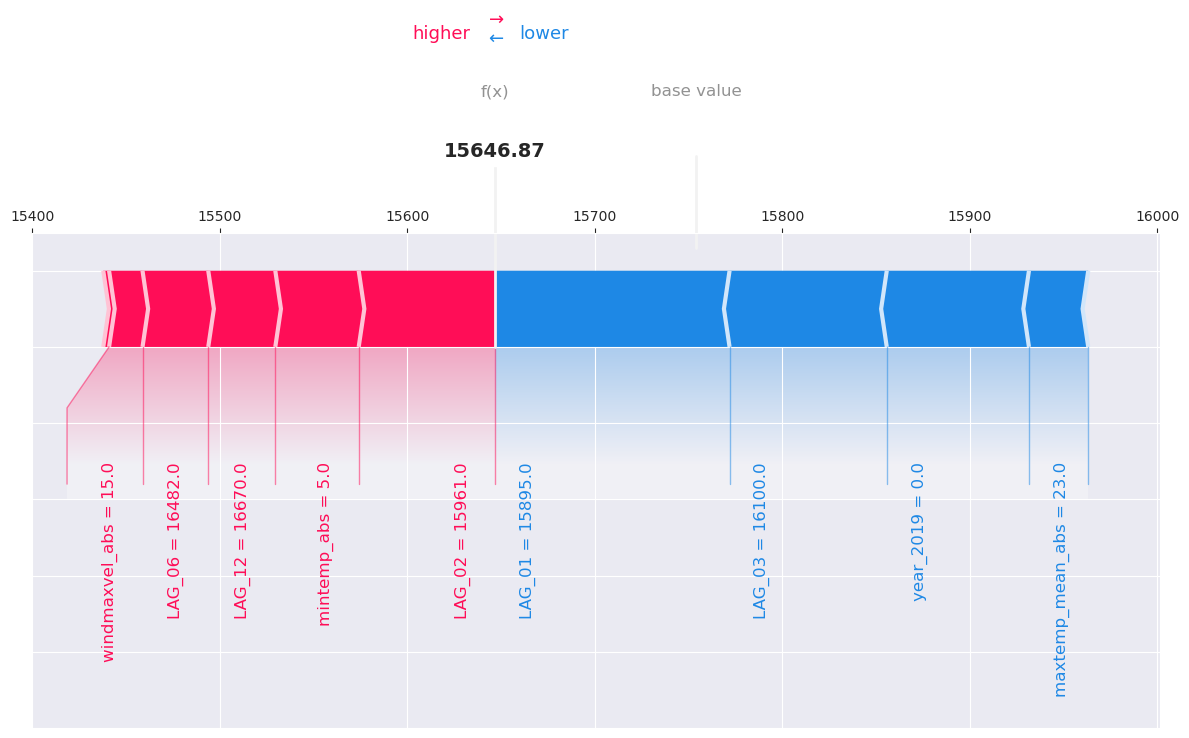

In [262]:
shap.initjs()

explainer_rf = shap.Explainer(rf)
shap_rf = explainer_rf(x_train)

base_values_rf = pd.DataFrame(index=x_train.columns)
values_rf = pd.DataFrame(index=x_train.columns)
data_rf = pd.DataFrame(index=x_train.columns)

for sample in shap_rf:
    base_values_rf = pd.concat([base_values_rf, pd.Series(sample.base_values, index=x_train.columns)], axis=1)
    values_rf = pd.concat([values_rf, pd.Series(sample.values, index=x_train.columns)], axis=1)
    data_rf = pd.concat([data_rf, pd.Series(sample.data, index=x_train.columns)], axis=1)

shap.plots.force(base_value=base_values_rf.mean(axis=1).to_numpy(),
                 shap_values=values_rf.mean(axis=1).to_numpy(),
                 features=data_rf.mean(axis=1).to_numpy().astype(int),
                 feature_names=x_train.columns,
                 matplotlib=True,
                 figsize=(12, 8),
                 text_rotation=90,
                 show=False)

plt.tight_layout()
plt.savefig("results/SHAP FORCE RF.png", bbox_inches='tight')
plt.show()


## XGBoost

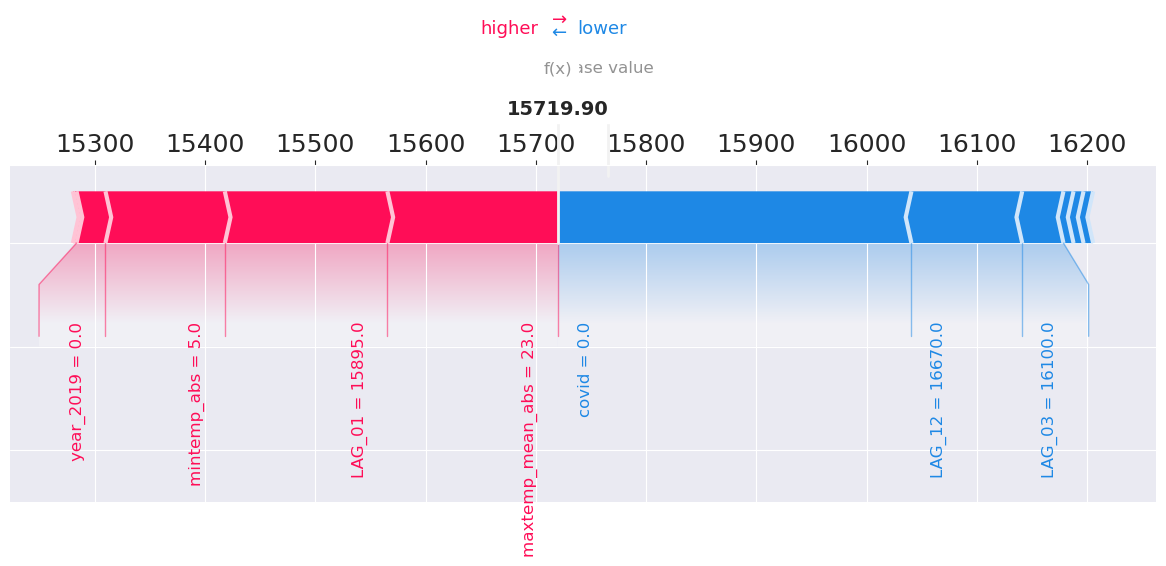

In [267]:
shap.initjs()

explainer_xgb = shap.Explainer(xgb)
shap_xgb = explainer_xgb(x_train)

base_values_xgb = pd.DataFrame(index=x_train.columns)
values_xgb = pd.DataFrame(index=x_train.columns)
data_xgb = pd.DataFrame(index=x_train.columns)
for sample in shap_xgb:
    base_values_xgb = pd.concat([base_values_xgb, pd.Series(sample.base_values, index=x_train.columns)], axis=1)
    values_xgb = pd.concat([values_xgb, pd.Series(sample.values, index=x_train.columns)], axis=1)
    data_xgb = pd.concat([data_xgb, pd.Series(sample.data, index=x_train.columns)], axis=1)


shap.plots.force(base_value=base_values_xgb.mean(axis=1).to_numpy(),
                 shap_values=values_xgb.mean(axis=1).to_numpy(),
                 features=data_xgb.mean(axis=1).to_numpy().astype(int),
                 feature_names=x_train.columns,
                 matplotlib=True,
                 figsize=(12, 6),
                 text_rotation=90,
                 show=False)

plt.tight_layout()
plt.savefig("results/SHAP FORCE XGB.png", bbox_inches='tight')
plt.show()


## Average - RF and XGB

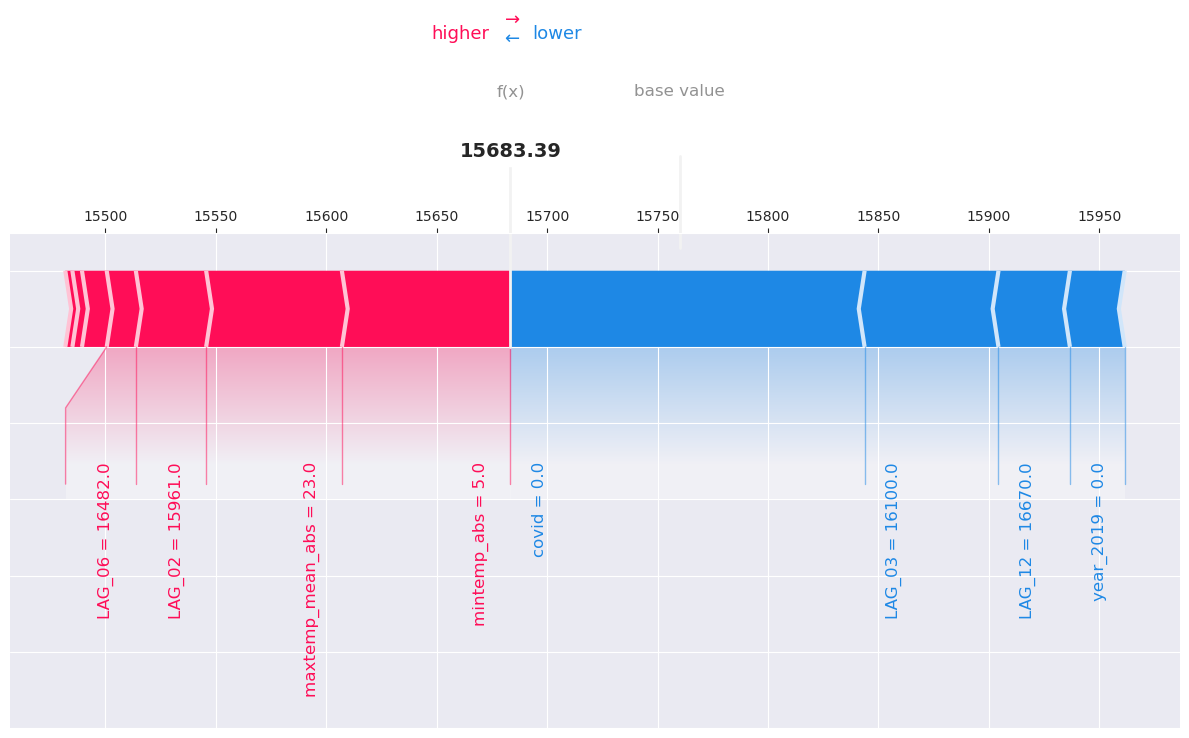

In [264]:
shap.initjs()

explainer_xgb = shap.Explainer(xgb)
shap_xgb = explainer_xgb(x_train)

base_values_avg = pd.concat([base_values_rf, base_values_xgb], axis=1)
values_avg = pd.concat([values_rf, values_xgb], axis=1)
data_avg = pd.concat([data_rf, data_xgb], axis=1)

shap.plots.force(base_value=base_values_avg.mean(axis=1).to_numpy(),
                 shap_values=values_avg.mean(axis=1).to_numpy(),
                 features=data_avg.mean(axis=1).to_numpy().astype(int),
                 feature_names=x_train.columns,
                 matplotlib=True,
                 figsize=(12, 8),
                 text_rotation=90,
                 show=False)

plt.tight_layout()
plt.savefig("results/SHAP FORCE AVERAGE.png", bbox_inches='tight')
plt.show()

